# Temporal Graph Neural Networks

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0
!pip install torch-geometric-temporal

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 729.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.6.0 requires pandas>=1.5.0, but you have pandas 1.3.5 which is incompatible.
cudf-c

## Forecasting web traffic

#### Here, we are trying to understand the pattern of the dataset by performing a rolling moving average 

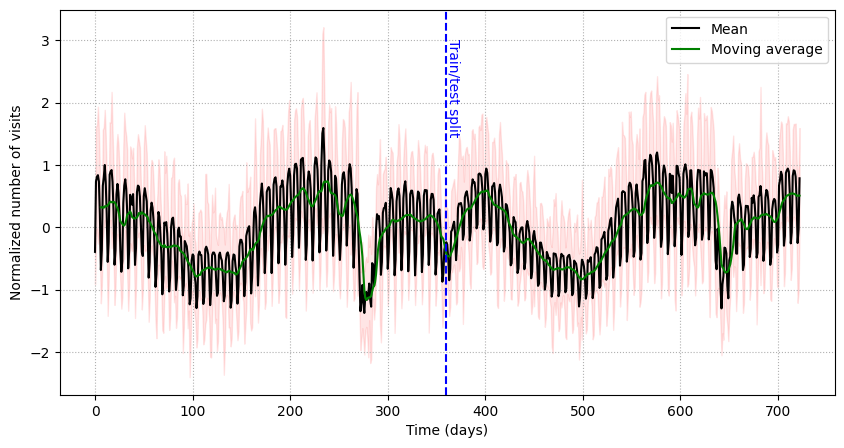

In [2]:
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df['rolling'] = df['mean'].rolling(7).mean()

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

### Applying TemporalGNN to predict the next Forecast of Web traffic

In [3]:
import torch
torch.manual_seed(0)

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|██████████| 50/50 [07:26<00:00,  8.92s/it]


MSE = 0.7893


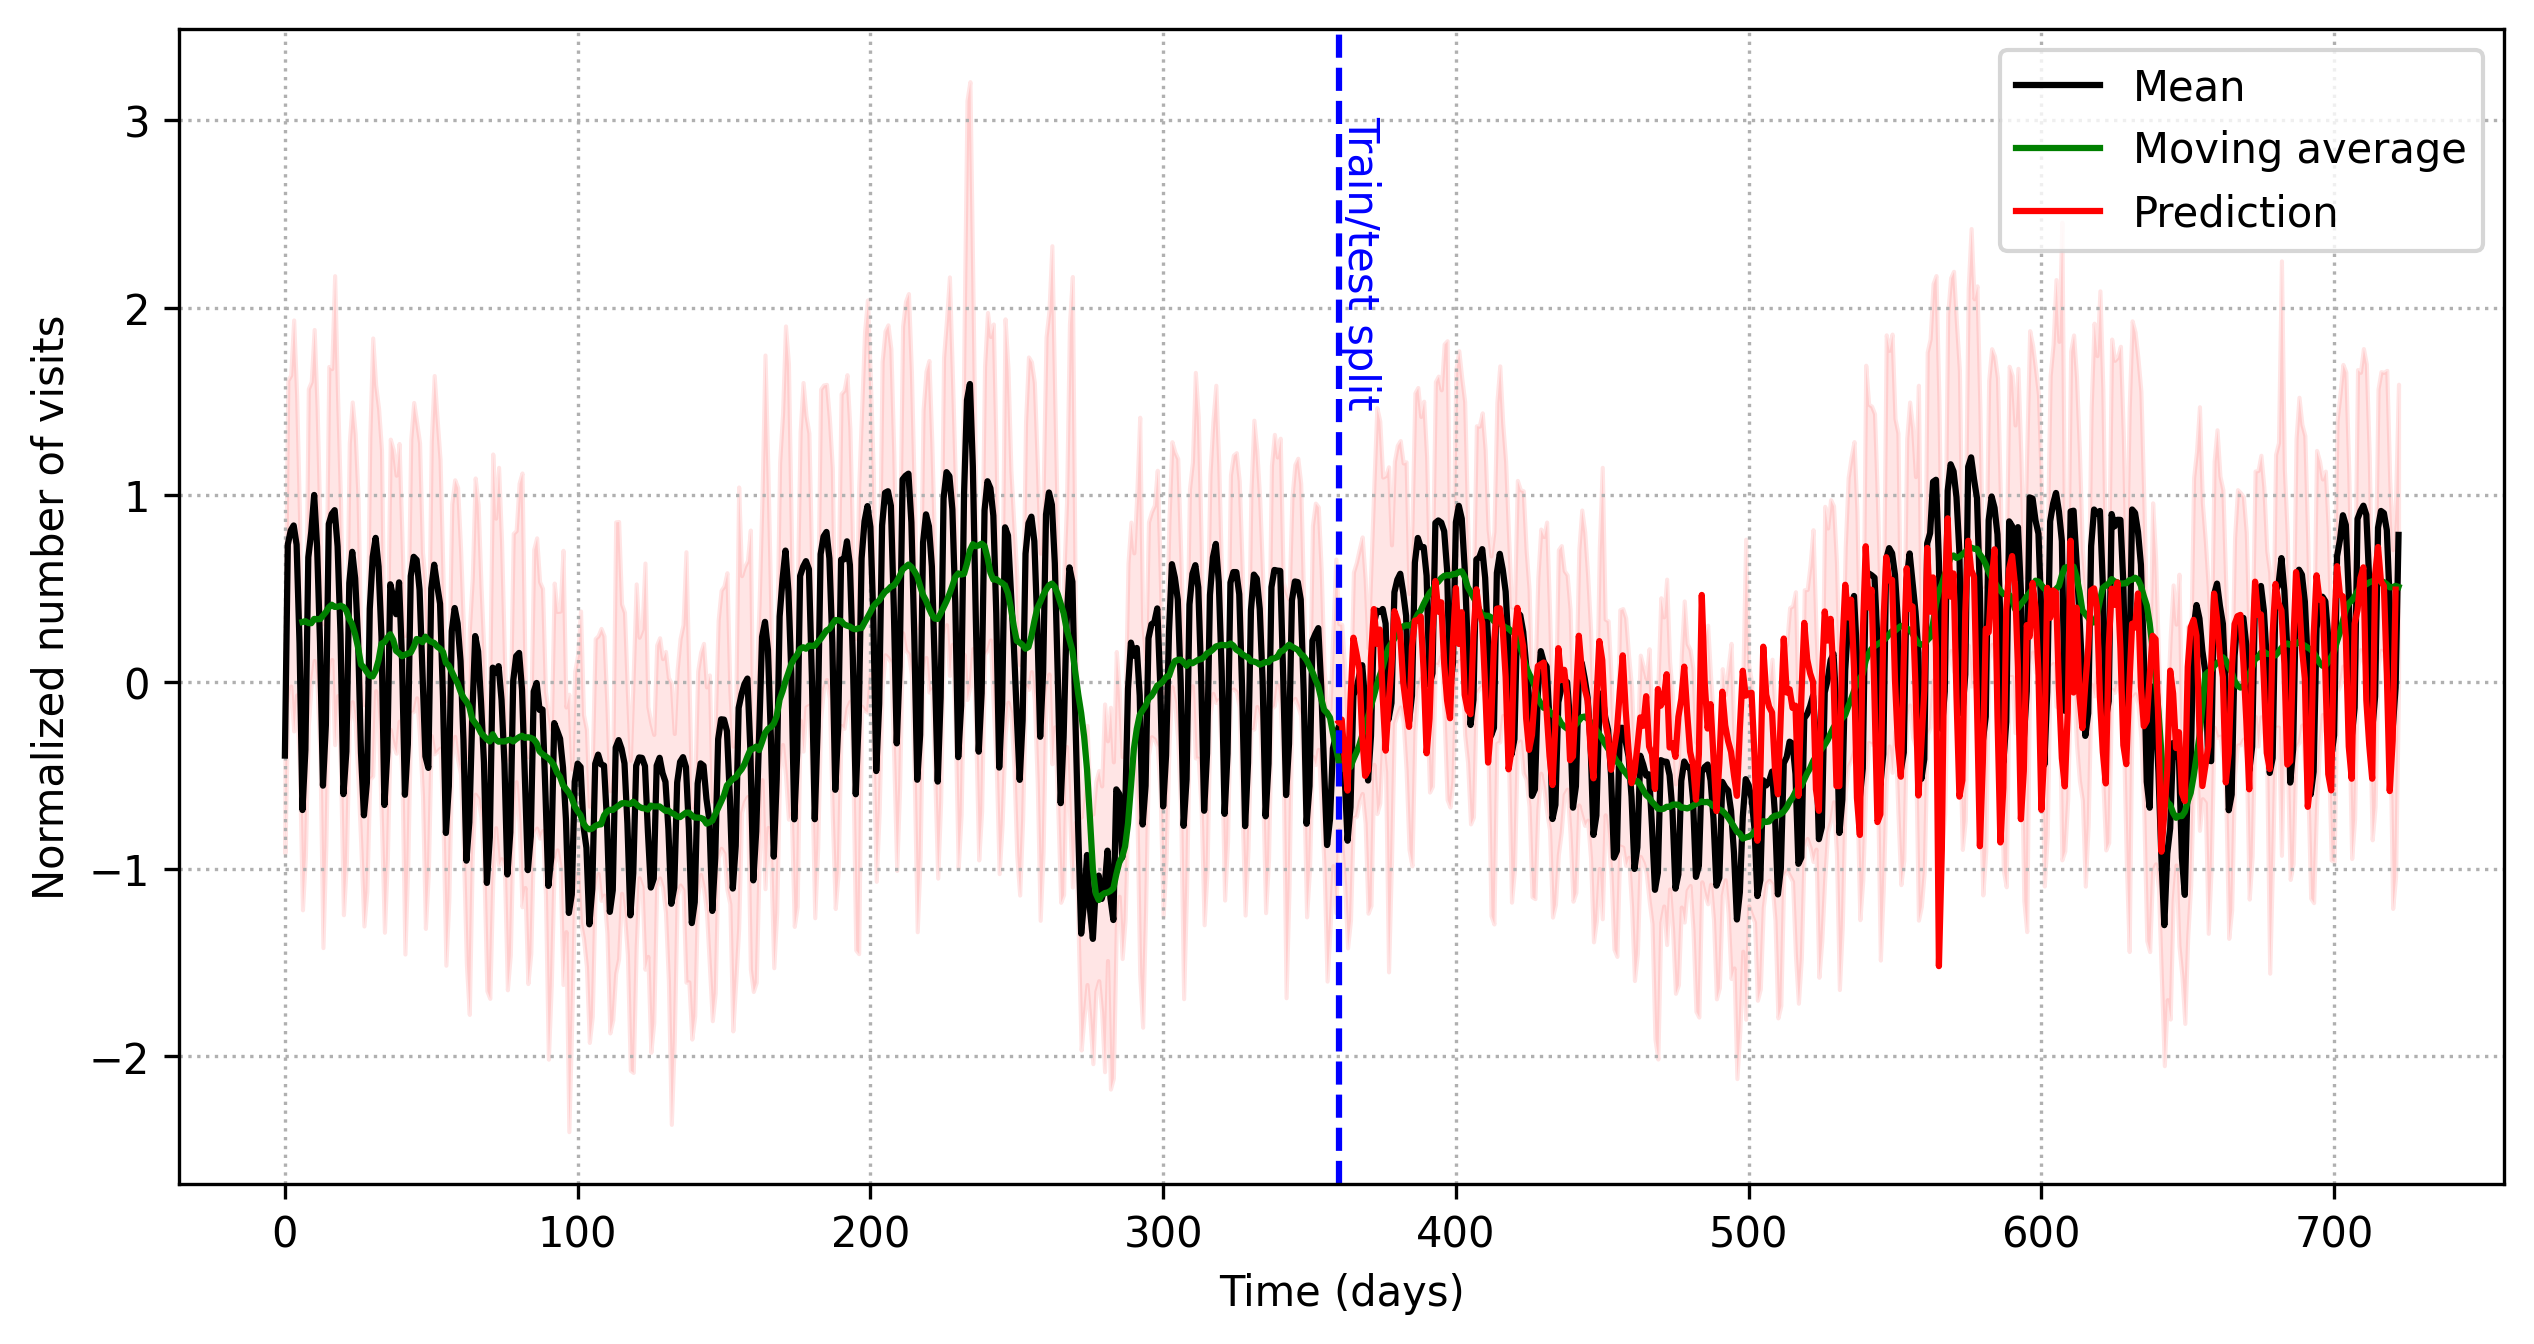

In [4]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() 
           for snapshot in test_dataset]
plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

### Conclusion:
We can analyse from the above red line over the actual that TemporalGNN was impressively successful in providing almost accurate predictions to the time points and pattern of when and how the web trafficking will occur due to number of visits.

<Axes: >

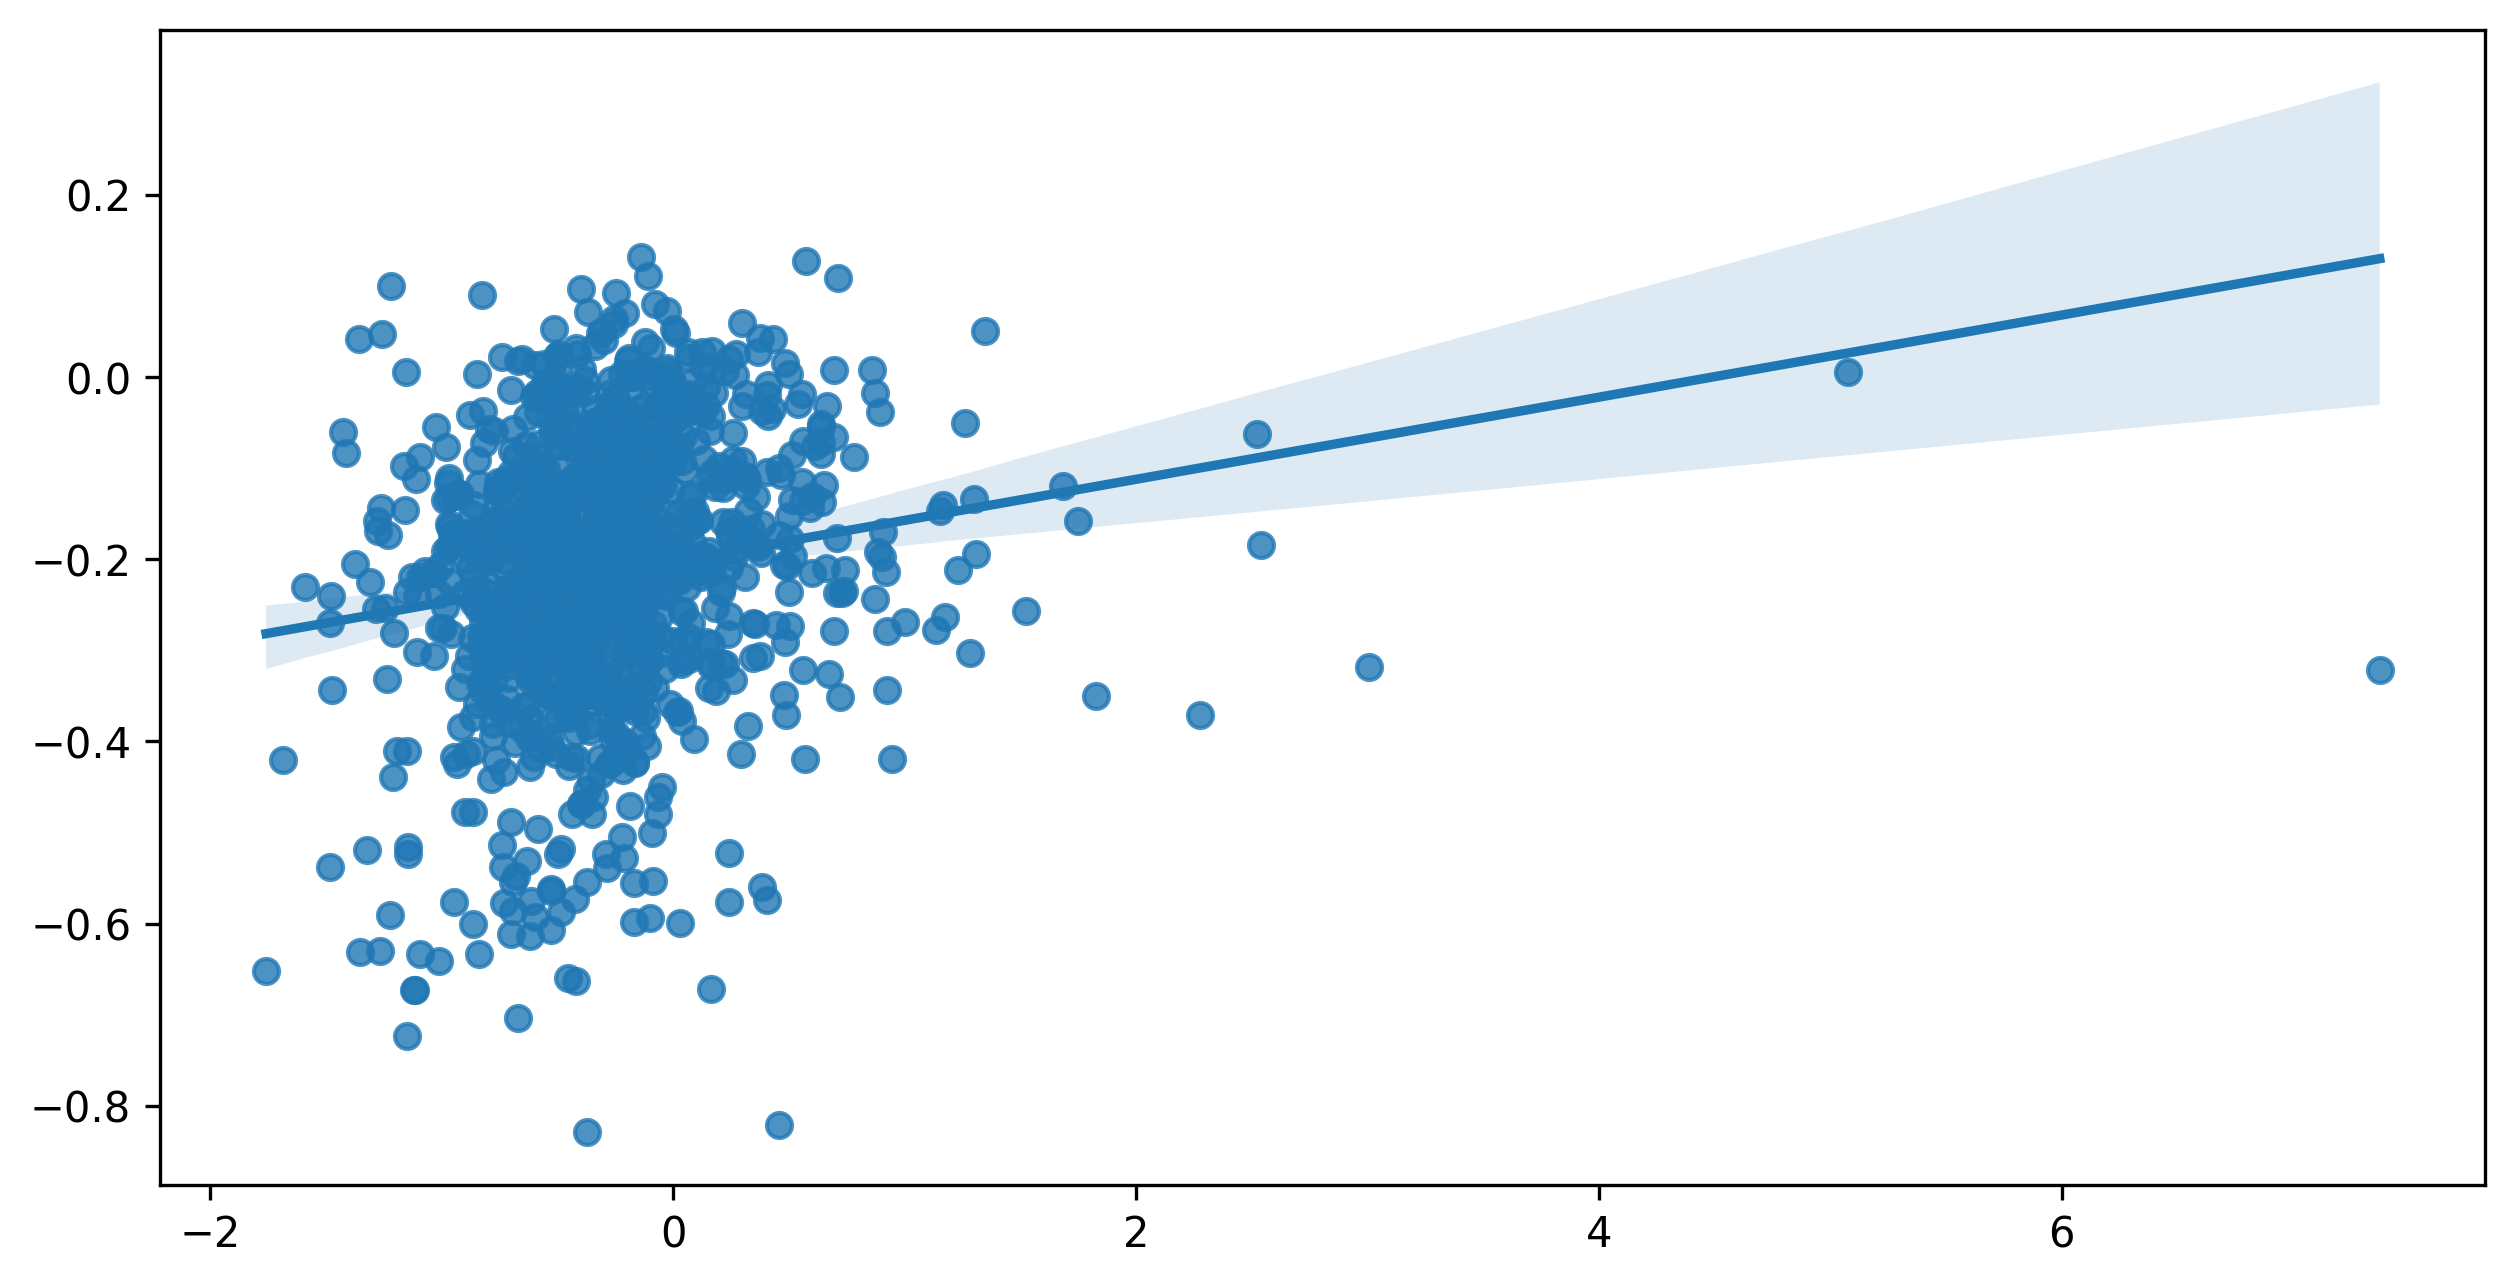

In [5]:
import seaborn as sns
y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()
plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

#### In the above plot we can observe that there is a cluster formed about the +-(0.2) range, depicting that the data was normalised and distributed by satifying the assumptions of normality.

## Now, let us consider a case where the data was not normally distributed and how the TemporalGNN was not a good performer in that case.

## Predicting cases of COVID-19

Text(0, 0.5, 'Mean normalized number of cases')

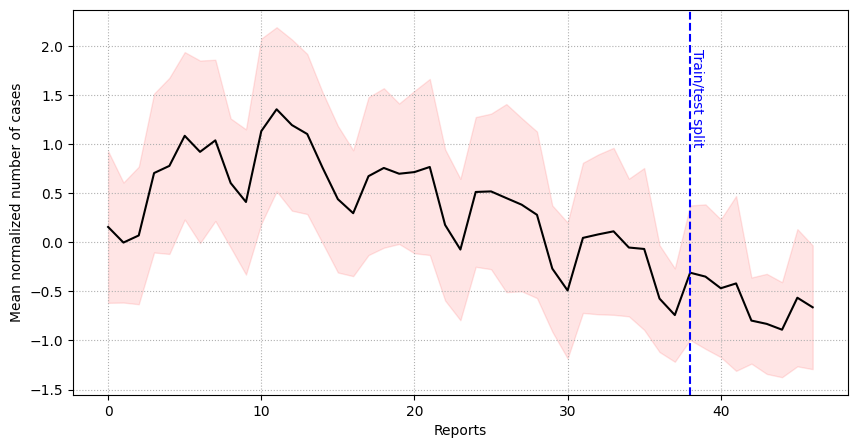

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

dataset = EnglandCovidDatasetLoader().get_dataset(lags=14)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])

plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Reports')
plt.ylabel('Mean normalized number of cases')

In [8]:
from torch_geometric_temporal.nn.recurrent import MPNNLSTM

class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, num_nodes):
        super().__init__()
        self.recurrent = MPNNLSTM(dim_in, dim_h, num_nodes, 1, 0.5)
        self.dropout = torch.nn.Dropout(0.5)
        self.linear = torch.nn.Linear(2*dim_h + dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.dropout(h)
        h = self.linear(h).tanh()
        return h

model = TemporalGNN(dataset[0].x.shape[1], 64, dataset[0].x.shape[0])
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

# Training
for epoch in tqdm(range(100)):
    loss = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = loss + torch.mean((y_pred-snapshot.y)**2)
    loss = loss / (i+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE: {loss.item():.4f}')

TemporalGNN(
  (recurrent): MPNNLSTM(
    (_convolution_1): GCNConv(14, 64)
    (_convolution_2): GCNConv(64, 64)
    (_batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (_recurrent_1): LSTM(128, 64)
    (_recurrent_2): LSTM(64, 64)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=142, out_features=1, bias=True)
)


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

MSE: 1.4751


Text(0, 0.5, 'Mean normalized number of cases')

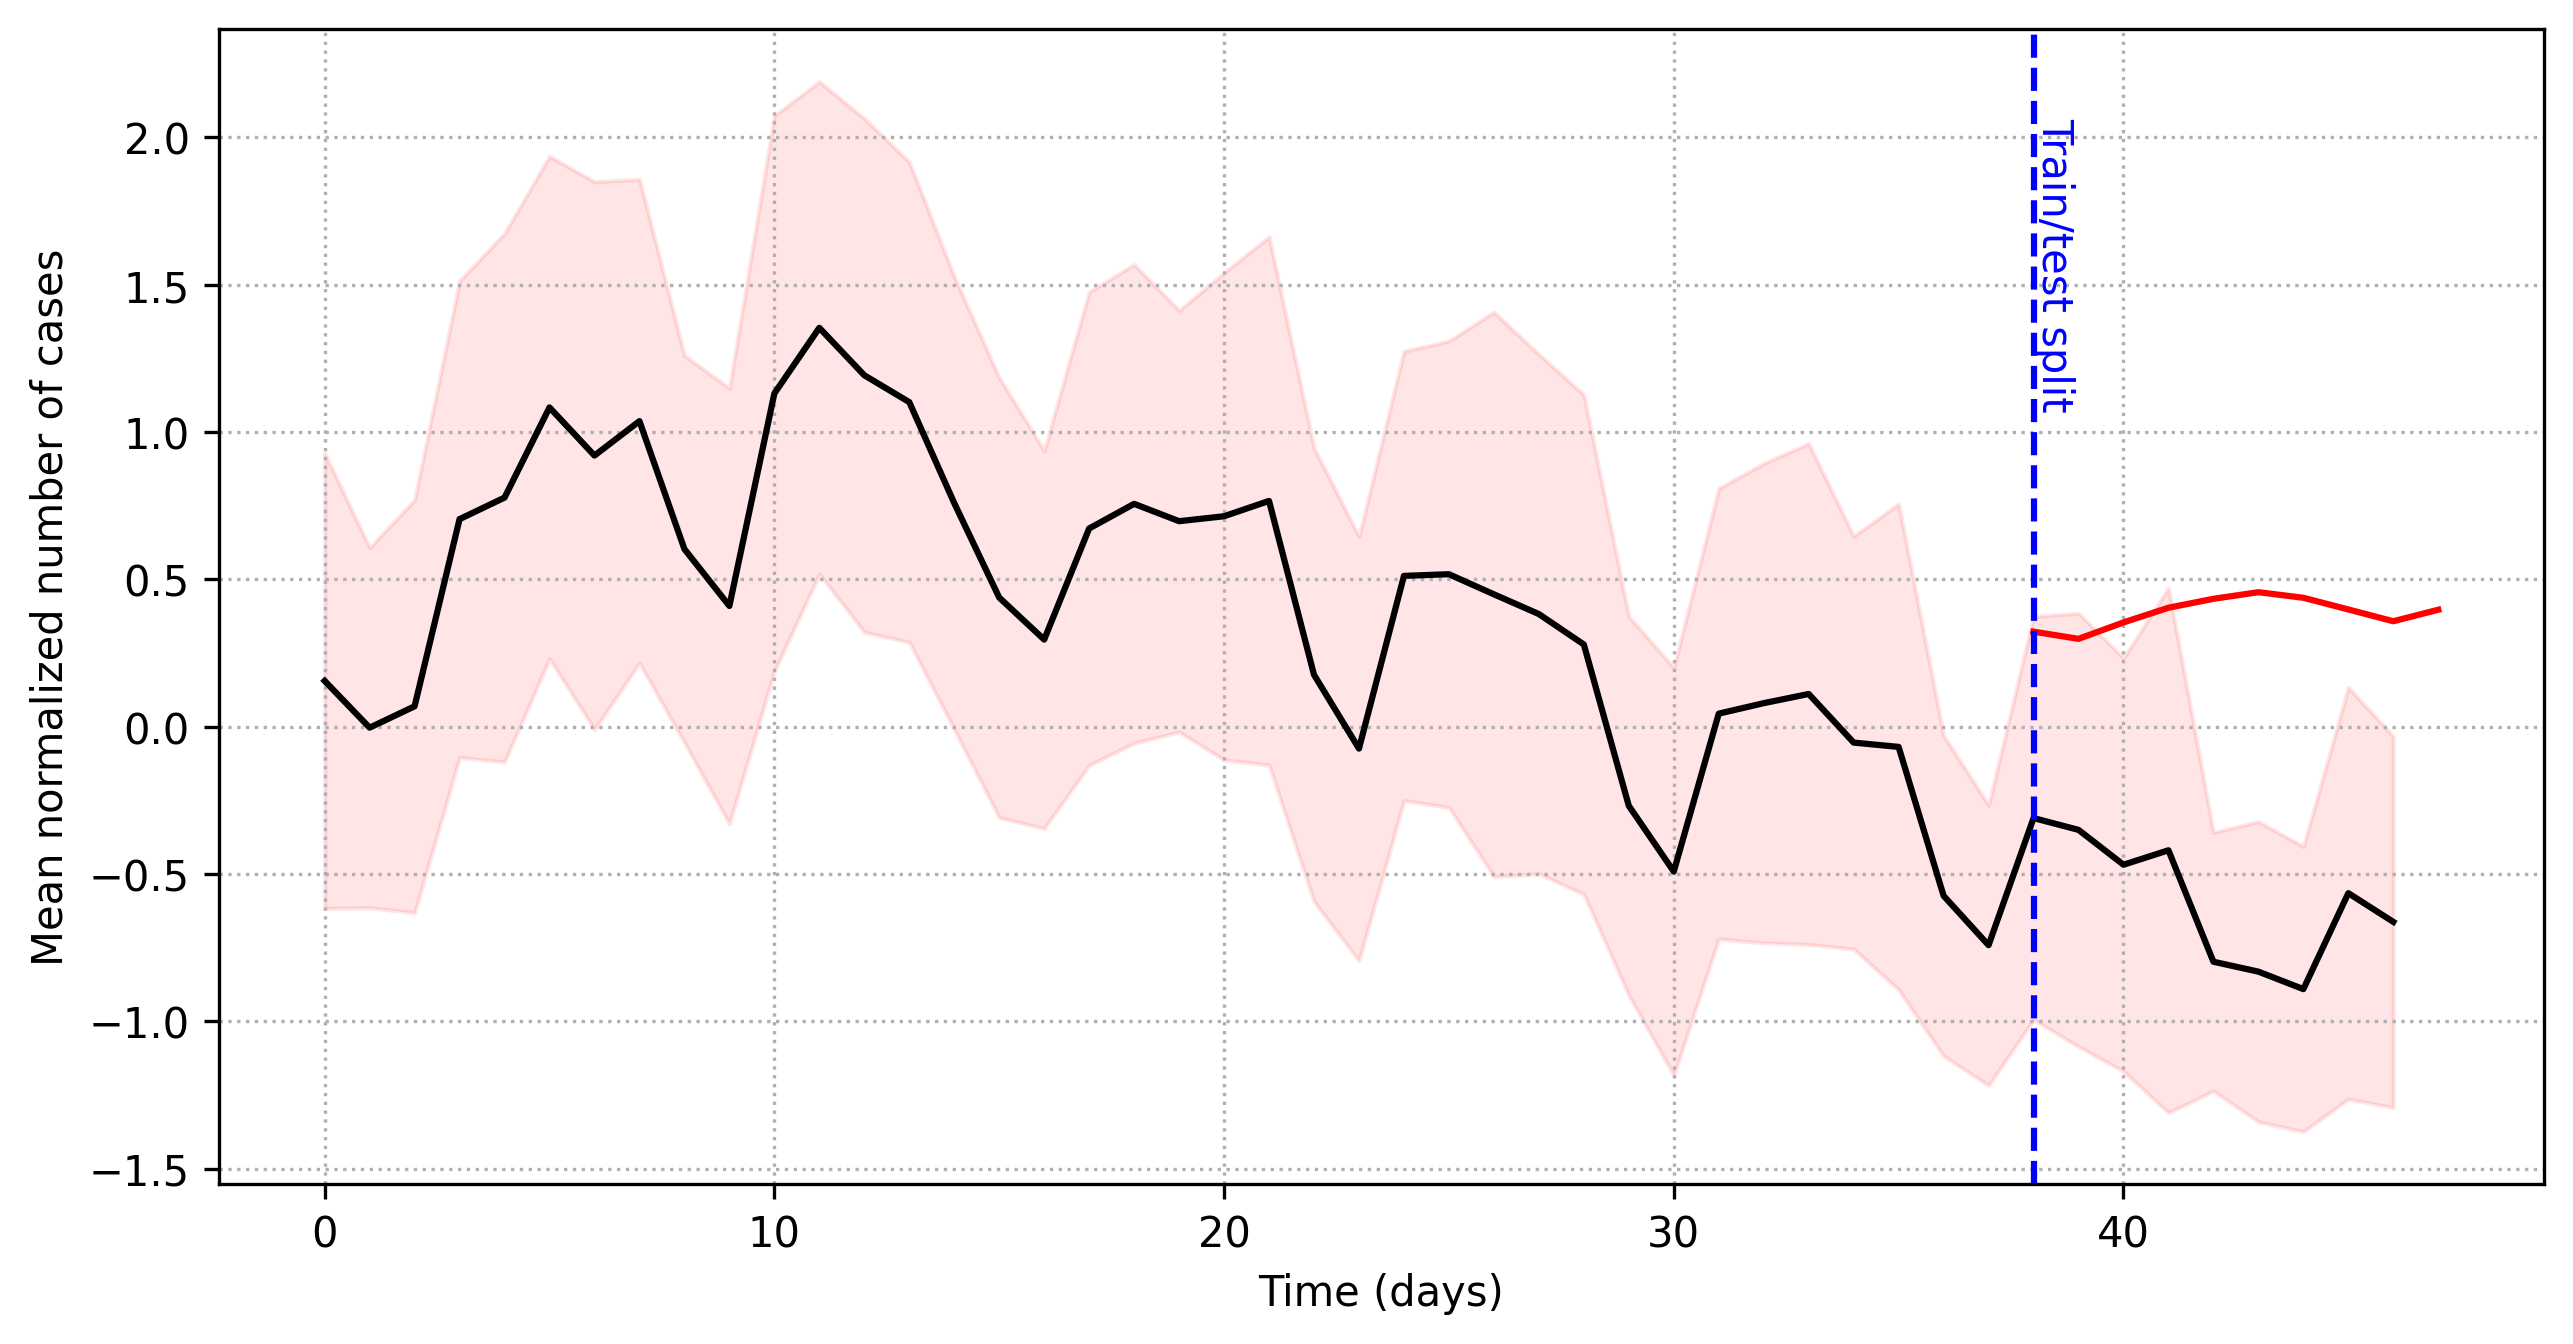

In [9]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-')
plt.plot(range(38,48), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=38, color='b', linestyle='--', label='Train/test split')
plt.text(38, 1.1, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Mean normalized number of cases')

## Conclusion: 

#### We can see in the above graph that the red prediction line is quite far from the actual line, rather opposite. This indicates that the covid cases may rise, however, in reality, the cases were falling with time. Hence, giving a wrong analytics. 

<Axes: >

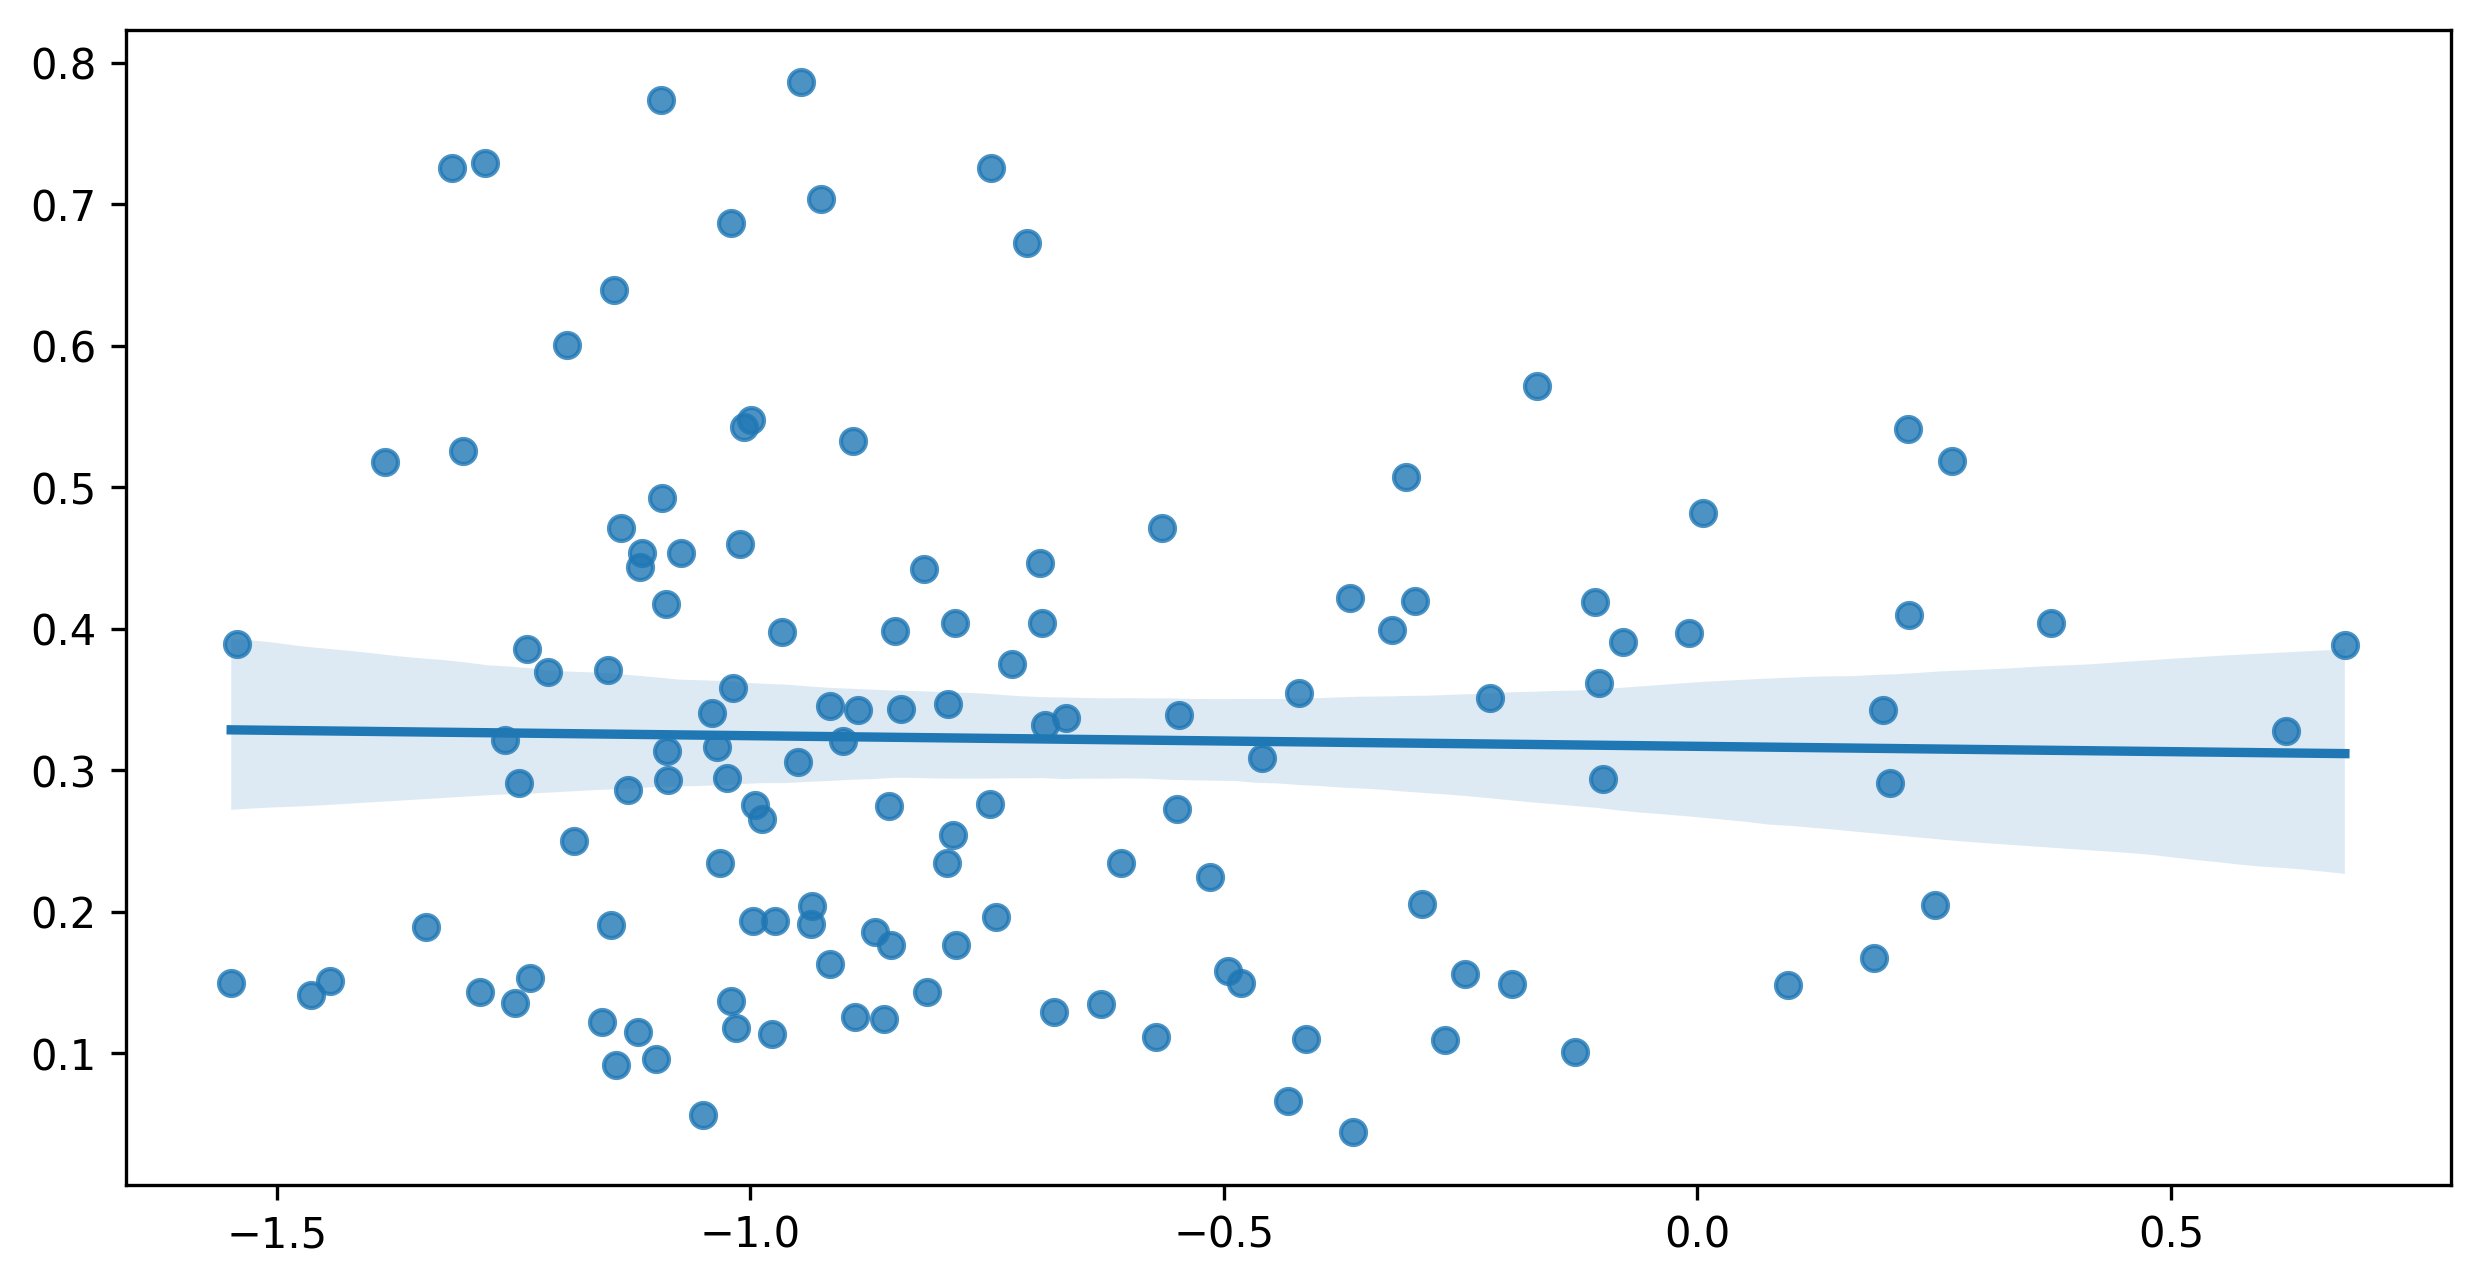

In [10]:
import seaborn as sns

y_pred = model(test_dataset[0].x, test_dataset[0].edge_index, test_dataset[0].edge_attr).detach().squeeze().numpy()

plt.figure(figsize=(10,5), dpi=300)
sns.regplot(x=test_dataset[0].y.numpy(), y=y_pred)

#### Hence, if the dataset is not normally distributed, the Temporal GNN may not perform well, and give misleading significance.